In [19]:
import harp
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from functools import reduce
import cv2
import numpy as np
import utils
import aeon.io.video as video
import aeon.analysis.movies as frame_helpers
from dotmap import DotMap

harp_reader = harp.create_reader('device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData()
rules_reader = utils.SessionData()
video_reader = utils.Video()

harp_datafolder = r'../temp_data_remote/2024-05-23T15-44-14/Expander/'
settings_datafolder = r'../temp_data_remote/2024-05-23T15-44-14/SessionSettings/'
rules_datafolder = r'../temp_data_remote/2024-05-23T15-44-14/RuleSettings/'
video_datafolder = r'../temp_data_remote/2024-05-23T15-44-14/VideoData/'
output_event_folder = r'../temp_data_remote/2024-05-23T15-44-14/EventResults/'

In [20]:
# read experiment metadata
session_settings = utils.load_json(session_data_reader, settings_datafolder)

rule_settings = utils.load_json(rules_reader, rules_datafolder)

print(session_settings)
print(rule_settings)

                                                                     metadata
2024-05-23 15:44:14.564479  {'lineMappings': {'odorMap': [DotMap(name='Odo...
                                                                     metadata
2024-05-23 15:44:14.564479  {'ruleAlias': 'Rule1', 'stateDefinitions': [{'...


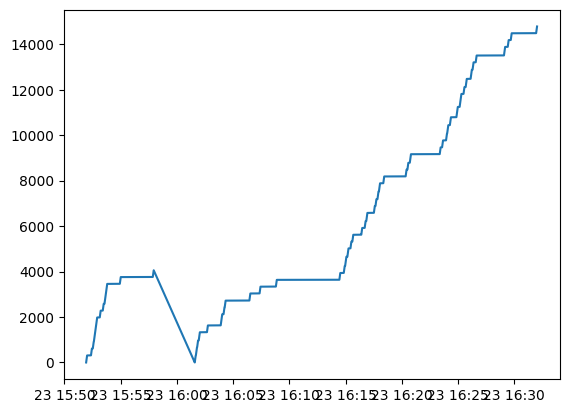

In [21]:
# read experiment video
video_data = utils.load_video(video_reader, video_datafolder)

plt.plot(video_data.index, video_data["_frame"])

In [22]:
# Read HARP device streams, conditioned on mappings found in the session metadata
metadata = session_settings.iloc[0]['metadata']
print(metadata.metadata.animalId)

# Extract line mappings from metadata
aux_line = f'Aux{metadata.lineMappings.auxLine}'
port_line = f'Out{metadata.lineMappings.portLine}'
vacuum_line = f'Out{metadata.lineMappings.vacuumLine}'
odorA = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorA'), None)}"
odorB = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorB'), None)}"
odorC = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorC'), None)}"
odorD = f"Out{next((x.line for x in metadata.lineMappings.odorMap if x.name=='OdorD'), None)}"

# Aux line containing poke events
poke_events = utils.load(harp_reader.AuxInState, harp_datafolder)[aux_line]

# times when outputs were set to HIGH (e.g. port valve opening, manifold valve opening)
outputs_HIGH = utils.load(harp_reader.OutputSet, harp_datafolder)
# times when outputs were set to LOW (e.g. port valve closing, manifold closing)
outputs_LOW = utils.load(harp_reader.OutputClear, harp_datafolder)

print(outputs_LOW[odorC])

# convert LOW and HIGH events to port state dataframes
line_states = {
    "poke_events": poke_events,
    "port_line_state": utils.concat_digi_events(outputs_LOW[port_line], outputs_HIGH[port_line]),
    "vacuum_line_state": utils.concat_digi_events(outputs_LOW[vacuum_line], outputs_HIGH[vacuum_line]),
    "odorA_state": utils.concat_digi_events(outputs_LOW[odorA], outputs_HIGH[odorA]),
    "odorB_state": utils.concat_digi_events(outputs_LOW[odorB], outputs_HIGH[odorB]),
    "odorC_state": utils.concat_digi_events(outputs_LOW[odorC], outputs_HIGH[odorC]),
    "odorD_state": utils.concat_digi_events(outputs_LOW[odorD], outputs_HIGH[odorD])
}

# consolidate digital lines into as single DataFrame
merged = pd.merge(line_states["poke_events"], line_states["port_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["vacuum_line_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorA_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorB_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorC_state"], left_on="Time", right_on="Time", how="outer") \
        .merge(line_states["odorD_state"], left_on="Time", right_on="Time", how="outer")

# rename columns according to metadata line mapping
merged.columns = line_states.keys()

# add additional meta information
merged['poke_count'] = (merged['poke_events'] * 1).cumsum(skipna=True).ffill()
merged['odor_count'] = (merged['odorA_state'] * 1).cumsum(skipna=True).ffill() + (merged['odorB_state'] * 1).cumsum(skipna=True).ffill() + \
                       (merged['odorC_state'] * 1).cumsum(skipna=True).ffill() + (merged['odorD_state'] * 1).cumsum(skipna=True).ffill()

print(merged)


CK002
Time
2024-05-23 15:44:37.789504051    False
2024-05-23 15:44:37.836480141    False
2024-05-23 15:44:37.839488029    False
2024-05-23 15:44:37.840479851     True
2024-05-23 15:44:37.842495918    False
                                 ...  
2024-05-23 16:31:59.320479870    False
2024-05-23 16:32:29.467487812    False
2024-05-23 16:32:29.468480110    False
2024-05-23 16:32:29.471487999     True
2024-05-23 16:32:29.472479820    False
Name: Out8, Length: 536, dtype: bool
                              poke_events port_line_state vacuum_line_state  \
Time                                                                          
2024-05-23 15:44:37.789504051         NaN           False               NaN   
2024-05-23 15:44:37.836480141         NaN             NaN               NaN   
2024-05-23 15:44:37.839488029         NaN             NaN               NaN   
2024-05-23 15:44:37.840479851         NaN             NaN               NaN   
2024-05-23 15:44:37.842495918         NaN        

C:\Users\neurogears\AppData\Local\Temp\ipykernel_26548\3975403799.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['poke_count'] = (merged['poke_events'] * 1).cumsum(skipna=True).ffill()
C:\Users\neurogears\AppData\Local\Temp\ipykernel_26548\3975403799.py:48: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['odor_count'] = (merged['odorA_state'] * 1).cumsum(skipna=True).ffill() + (merged['odorB_state'] * 1).cumsum(skipna=True).ffill() + \
C:\Users\neurogears\AppData\Local\Temp\ipykernel_26548\3975403799.py:49: FutureWarning: Downcasting ob

In [24]:
# Extract initiating events
merged["initiating_event"] = False

diffs = (merged["port_line_state"].ffill() * 1).diff()
port_events = merged["port_line_state"][diffs==1][1::2]

for i in port_events.index:
    pre_events = merged[merged.index <= (i - pd.Timedelta(seconds=metadata.metadata.minimumPokeTime))]
    initiating_poke_event = pre_events[pre_events["poke_events"] == True].iloc[[-1]]
    merged.loc[initiating_poke_event.index, "initiating_event"] = True
    
merged['initiating_event_count'] = (merged['initiating_event'] * 1).cumsum(skipna=True).ffill()
print(merged)

                              poke_events port_line_state vacuum_line_state  \
Time                                                                          
2024-05-23 15:44:37.789504051         NaN           False               NaN   
2024-05-23 15:44:37.836480141         NaN             NaN               NaN   
2024-05-23 15:44:37.839488029         NaN             NaN               NaN   
2024-05-23 15:44:37.840479851         NaN             NaN               NaN   
2024-05-23 15:44:37.842495918         NaN             NaN               NaN   
...                                   ...             ...               ...   
2024-05-23 16:31:59.320479870         NaN             NaN             False   
2024-05-23 16:32:29.467487812         NaN             NaN               NaN   
2024-05-23 16:32:29.468480110         NaN             NaN               NaN   
2024-05-23 16:32:29.471487999         NaN             NaN               NaN   
2024-05-23 16:32:29.472479820         NaN           

C:\Users\neurogears\AppData\Local\Temp\ipykernel_26548\4140541040.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diffs = (merged["port_line_state"].ffill() * 1).diff()


In [24]:
# Using the consolidated data sets, do an example plot centered around a poke event

def extract_event_info(experiment_state: pd.DataFrame, rule_state: pd.DataFrame, event_time: pd.Timestamp, time_offset: float, metadata: DotMap):
    # get time window around event
    start_time = event_time - pd.Timedelta(seconds=time_offset)
    end_time = event_time + pd.Timedelta(seconds=time_offset)

    # slice data in this time window
    event_data = experiment_state[start_time : end_time]
    event_vid = video_data[start_time : end_time]

    # additional meta information
    animal_id = metadata.metadata.animalId
    cur_state = experiment_state.ffill().loc[experiment_state.index <= event_time].iloc[[-1]]
    current_rule = rule_state[rule_state.index <= event_time]["metadata"].iloc[-1]

    cur_odor = [state for state in ['odorA_state', 'odorB_state', 'odorC_state', 'odorD_state'] if cur_state[state][0]]
    cur_odor = cur_odor[0] if len(cur_odor)>0 else None
    if cur_odor is None:
        odor_name = 'None'
        odor_line = np.nan
    else:
        odor_name = cur_odor.split('_')[0].capitalize()
        odor_name = odor_name[:-1] + odor_name[-1].upper()
        odor_line = [o.line for o in metadata.lineMappings.odorMap if o.name==odor_name][0]

    time_beam_break_on = event_time
    time_beam_break_off = experiment_state.loc[(experiment_state['poke_events'] == False) & (experiment_state.index > event_time)].index[0]

    time_port_open = experiment_state.loc[(experiment_state['port_line_state'] == True) & (experiment_state.index > event_time)].index[0]
    time_port_close = experiment_state.loc[(experiment_state['port_line_state'] == False) & (experiment_state.index > event_time)].index[0]

    time_odor_open = experiment_state.loc[(experiment_state[cur_odor] == True) & (experiment_state.index <= event_time)].index[0] if cur_odor else None
    time_odor_close = experiment_state.loc[(experiment_state[cur_odor] == False) & (experiment_state.index > event_time)].index[0] if cur_odor else None

    next_poke_valves = (experiment_state[experiment_state.index > time_port_close])[['odorA_state', 'odorB_state', 'odorC_state', 'odorD_state']].sum(axis=1)
    next_odor_time = next_poke_valves[next_poke_valves == 1].index[0]
    next_poke_time = experiment_state.loc[(experiment_state.index > time_port_close) & (experiment_state['poke_events'] == True)]['poke_events']
    next_poke_time = (next_poke_time.index[0] if (len(next_poke_time)>0) else np.nan)

    # summarise in data frame
    event_df = pd.DataFrame({
        'animal_id': animal_id,
        'current_rule': current_rule.ruleAlias,
        'current_odor': odor_name,
        'odor_line': odor_line,
        'port_line': metadata.lineMappings.portLine,
        'vacuum_line': metadata.lineMappings.vacuumLine,
        'aux_line': metadata.lineMappings.auxLine,
        'poke_state': cur_state['poke_events'],
        'initiating_event': cur_state['initiating_event'],
        'port_line_state': cur_state['port_line_state'],
        'vacuum_line_state': cur_state['vacuum_line_state'],
        'odorA_state': cur_state['odorA_state'],
        'odorB_state': cur_state['odorB_state'],
        'odorC_state': cur_state['odorC_state'],
        'odorD_state': cur_state['odorD_state'],
        'beam_break_count': cur_state['poke_count'],
        'odor_count': cur_state['odor_count'],
        'initiating_event_count': cur_state['initiating_event_count'],
        'beam_break_on': time_beam_break_on,
        'beam_break_off': time_beam_break_off,
        'port_open': time_port_open,
        'port_close': time_port_close,
        'odor_open': time_odor_open,
        'odor_close': time_odor_close,
        'next_odor': next_odor_time,
        'next_poke': next_poke_time
    })

    return event_data, event_vid, event_df

# Get all the poke onset events, then extract the event times
poke_events = merged["poke_events"][merged["poke_events"]==True]
poke_event_times = [poke_events.iloc[[t]].index[0] for t in range(len(poke_events))]
    
results = [extract_event_info(merged, rule_settings, t, 2.0, metadata) for t in poke_event_times]
print(results)
summary = pd.concat([r[2] for r in results])
summary.to_csv(f'{output_event_folder}summary.csv')

[(                              poke_events port_line_state vacuum_line_state  \
Time                                                                          
2024-05-15 17:53:37.521247864        True             NaN               NaN   
2024-05-15 17:53:37.565504074         NaN            True               NaN   
2024-05-15 17:53:38.359936237       False             NaN               NaN   
2024-05-15 17:53:38.400479794         NaN           False               NaN   
2024-05-15 17:53:38.420512199         NaN             NaN               NaN   
2024-05-15 17:53:38.421504021         NaN             NaN               NaN   
2024-05-15 17:53:38.422495842         NaN             NaN               NaN   
2024-05-15 17:53:38.428480148         NaN             NaN               NaN   
2024-05-15 17:53:38.439487934         NaN             NaN               NaN   
2024-05-15 17:53:38.445504189         NaN             NaN               NaN   
2024-05-15 17:53:38.446496010         NaN         

C:\Users\neurogears\AppData\Local\Temp\ipykernel_32928\3592185595.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cur_state = experiment_state.ffill().loc[experiment_state.index <= event_time].iloc[[-1]]
C:\Users\neurogears\AppData\Local\Temp\ipykernel_32928\3592185595.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cur_odor = [state for state in ['odorA_state', 'odorB_state', 'odorC_state', 'odorD_state'] if cur_state[state][0]]


C:\Users\neurogears\AppData\Local\Temp\ipykernel_35388\3905489739.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.plot(event_data["poke_events"].ffill(), drawstyle = 'steps-post')
C:\Users\neurogears\AppData\Local\Temp\ipykernel_35388\3905489739.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title(f"Rule: {event_df['current_rule'][0]}")


[Text(0, -0.25, 'event'),
 Text(0, 0.55, 'poke'),
 Text(0, 1.65, 'port_line'),
 Text(0, 2.75, 'odorA'),
 Text(0, 3.85, 'odorB'),
 Text(0, 4.95, 'odorC'),
 Text(0, 6.05, 'video_frames')]

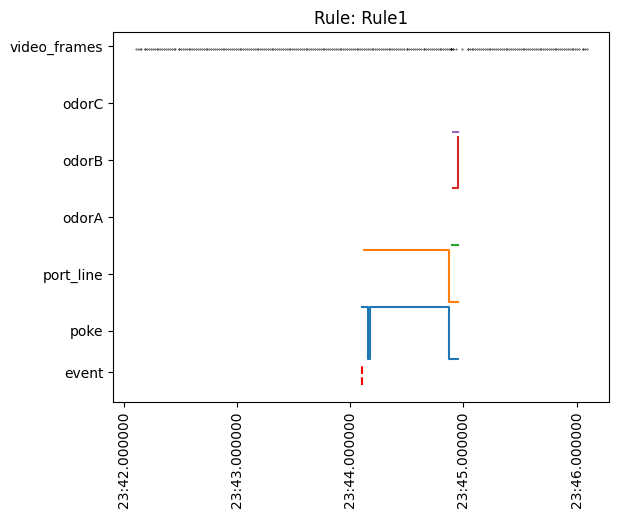

In [42]:
# Construct a plot of one of these results
event_idx = 84
event_data = results[event_idx][0]
event_vid = results[event_idx][1]
event_df = results[event_idx][2]
fig = plt.figure()

plt.plot([event_df.index[0], event_df.index[0]], [-0.5, -0.1], c='r', linestyle='dashed')
plt.plot(event_data["poke_events"].ffill(), drawstyle = 'steps-post')
plt.plot(event_data["port_line_state"].ffill() + 1.1, drawstyle = 'steps-post')
plt.plot(event_data["odorA_state"].ffill() + 2.2, drawstyle = 'steps-post')
plt.plot(event_data["odorB_state"].ffill() + 3.3, drawstyle = 'steps-post')
plt.plot(event_data["odorC_state"].ffill() + 4.4, drawstyle = 'steps-post')
plt.scatter(event_vid.index, np.ones((1, len(event_vid.index))) * 6, c='k', s=0.1)
plt.xticks(rotation=90)
plt.title(f"Rule: {event_df['current_rule'][0]}")

ax = fig.axes[0]
ax.set_yticks([-0.25, 0.55, 1.65, 2.75, 3.85, 4.95, 6.05])
ax.set_yticklabels(['event', 'poke', 'port_line', 'odorA', 'odorB', 'odorC', 'video_frames'])

In [64]:
def create_event_video(experiment_state: pd.DataFrame, event_frame_data: pd.DataFrame, event_df: pd.DataFrame):
    # get all frames
    frames = [f for f in video.frames(event_frame_data)]

    # create annotated video
    annotated_frames = []
    event_time = event_df.index
    for i, f in enumerate(frames):
        cur_t = event_frame_data.index[i]
        relative_t = (cur_t - event_time)[0].total_seconds()
        cur_state = experiment_state.ffill().loc[experiment_state.index <= cur_t].iloc[-1]
        current_rule = event_df["current_rule"][0]

        cv2.putText(f, f'Animal : {metadata.metadata.animalId}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)

        cv2.putText(f, f'Rule : {current_rule}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
        cv2.putText(f, f'HARP Time : {cur_t}', (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
        cv2.putText(f, f'Current stimulus : {int(cur_state["odor_count"])}', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
        cv2.putText(f, f'Time to event (s) : {relative_t}', (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)

        cv2.putText(f, f"Aux state : {cur_state.fillna(False)['poke_events']}", (10, 180), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state.fillna(False)['poke_events'] else (0, 0, 255), 2, 1)
        cv2.putText(f, f"Port state : {cur_state['port_line_state']}", (10, 210), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['port_line_state'] else (0, 0, 255), 2, 1)
        cv2.putText(f, f"OdorA state : {cur_state['odorA_state']}", (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['odorA_state'] else (0, 0, 255), 2, 1)
        cv2.putText(f, f"OdorB state : {cur_state['odorB_state']}", (10, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['odorB_state'] else (0, 0, 255), 2, 1)
        cv2.putText(f, f"OdorC state : {cur_state['odorC_state']}", (10, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0) if cur_state['odorC_state'] else (0, 0, 255), 2, 1)

        cv2.putText(f, f"Poke count : {cur_state['poke_count']}", (10, 330), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2, 1)
        annotated_frames.append(f)

    return annotated_frames
        
for i, r in enumerate(results):
    annotated = create_event_video(merged, r[1], r[2])

    vid_path = f'{output_event_folder}Stimulus-{int(r[2]["odor_count"].iloc[0])}-Event-{(i+1)}-{str(r[2].index[0]).replace(" ", "").replace(":", "T")}.mp4'

    print(vid_path)
    video.export(annotated, vid_path, 50)

C:\Users\neurogears\AppData\Local\Temp\ipykernel_35388\1909585882.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cur_state = experiment_state.ffill().loc[experiment_state.index <= cur_t].iloc[-1]
C:\Users\neurogears\AppData\Local\Temp\ipykernel_35388\1909585882.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_rule = event_df["current_rule"][0]


../temp_data/2024-03-07T16-07-59/EventResults/Stimulus-1-Event-1-2024-03-0716T19T50.508831978.mp4
../temp_data/2024-03-07T16-07-59/EventResults/Stimulus-1-Event-2-2024-03-0716T19T50.641568184.mp4
../temp_data/2024-03-07T16-07-59/EventResults/Stimulus-2-Event-3-2024-03-0717T23T33.327648163.mp4
../temp_data/2024-03-07T16-07-59/EventResults/Stimulus-3-Event-4-2024-03-0717T23T33.581664085.mp4
../temp_data/2024-03-07T16-07-59/EventResults/Stimulus-3-Event-5-2024-03-0720T03T20.604032040.mp4
../temp_data/2024-03-07T16-07-59/EventResults/Stimulus-4-Event-6-2024-03-0720T05T42.121888161.mp4
../temp_data/2024-03-07T16-07-59/EventResults/Stimulus-5-Event-7-2024-03-0721T25T17.398623943.mp4
../temp_data/2024-03-07T16-07-59/EventResults/Stimulus-5-Event-8-2024-03-0721T25T17.946944237.mp4
../temp_data/2024-03-07T16-07-59/EventResults/Stimulus-6-Event-9-2024-03-0721T25T41.848735809.mp4


KeyboardInterrupt: 